# Random Forest (Best Pipeline)

This notebook implements the **best-performing** Random Forest pipeline:

1. Load and preprocess the data 
2. Remove outliers from the training set using Isolation Forest
3. Encode labels with a `LabelEncoder`
4. Apply **Recursive Feature Elimination (RFE)** to select top features
5. Perform **GridSearchCV** hyperparameter tuning 
6. Train and evaluate the final classifier (with classification report,confusion matrix, ROC/AUC, feature importances)

This notebook uses the best results I found after analysing many combinations of scenarios. Please view `src/alex/random_forest.py` for the entire python file of work, and `src/alex/random_forest_analysis.ipynb` for a summarized pre-rendered notebook of all of these runs.

In [16]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
)
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder

# project imports
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

from preprocessing import preprocess, get_labels
from alex.outlier_utils import isolation_forest_mask, remove_outliers
from alex.plots import plot_confusion_matrix, plot_roc_curve, plot_feature_importances

In [17]:
train_path = os.path.join(PROJECT_ROOT, "data", "train_data.csv")
test_path = os.path.join(PROJECT_ROOT, "data", "test_data.csv")

df_train = pd.read_csv(train_path, index_col=0)
df_test = pd.read_csv(test_path, index_col=0)

# Shared preprocessing 
X_train_df = preprocess(df_train, attr=[])
X_test_df = preprocess(df_test, attr=[])

y_train_series = get_labels(df_train)["Plant_Health_Status"]
y_test_series = get_labels(df_test)["Plant_Health_Status"]

X_train_df.head(), y_train_series.value_counts(normalize=True), y_test_series.value_counts(normalize=True)

(                            Soil_Moisture  Ambient_Temperature  \
 Timestamp                                                        
 2024-10-29 16:54:53.426551      -1.153141            -0.041673   
 2024-10-30 10:54:53.473520       0.781295            -0.478532   
 2024-10-10 10:54:53.486512      -1.591389             0.381452   
 2024-10-25 04:54:53.467524       0.149233             0.235021   
 2024-10-04 10:54:53.467524      -0.845677             1.242659   
 
                             Soil_Temperature  Humidity  Light_Intensity  \
 Timestamp                                                                 
 2024-10-29 16:54:53.426551         -0.934143 -0.310509        -0.088358   
 2024-10-30 10:54:53.473520          0.180041  1.092487        -0.179602   
 2024-10-10 10:54:53.486512          0.936454  1.253537        -1.592484   
 2024-10-25 04:54:53.467524         -1.471607 -1.169741        -0.629102   
 2024-10-04 10:54:53.467524          0.459259  1.033675        -1.092800 

## Outlier removal using Isolation Forest

In [18]:
# Remove outliers on TRAIN ONLY
inlier_mask, scores, iso_model = isolation_forest_mask(
    X_train_df,
    n_estimators=200,
    contamination=0.05,   # already tuned in IF notebook
    random_state=42,
)
X_train_clean, y_train_clean_series = remove_outliers(
    X_train_df, inlier_mask, y_train_series
)

print(f"Train size before IF: {len(X_train_df)}, after IF: {len(X_train_clean)}")

X_train_clean.head()

Train size before IF: 900, after IF: 855


,Soil_Moisture,Ambient_Temperature,Soil_Temperature,Humidity,Light_Intensity,Soil_pH,Nitrogen_Level,Phosphorus_Level,Potassium_Level,Chlorophyll_Content,Electrochemical_Signal
Timestamp,,,,,,,,,,,
2024-10-29 16:54:53.426551,-1.153141,-0.041673,-0.934143,-0.310509,-0.088358,1.565693,-1.311790,-0.909479,-0.775000,0.798440,1.399687
2024-10-30 10:54:53.473520,0.781295,-0.478532,0.180041,1.092487,-0.179602,0.290128,0.892456,-1.081108,-0.284476,0.505690,-0.542319
2024-10-10 10:54:53.486512,-1.591389,0.381452,0.936454,1.253537,-1.592484,0.981499,-0.268331,0.505803,1.360979,0.423026,-1.002989
2024-10-25 04:54:53.467524,0.149233,0.235021,-1.471607,-1.169741,-0.629102,-0.346469,-1.519919,-1.730016,-0.011388,1.322704,-1.515979
2024-10-04 10:54:53.467524,-0.845677,1.242659,0.459259,1.033675,-1.092800,0.688706,-0.916270,-0.965395,0.755495,-1.348596,-0.571182


In [19]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_clean_series.values)
y_test = label_encoder.transform(y_test_series.values)

X_train = X_train_clean.values
X_test = X_test_df.values

X_train.shape, X_test.shape, np.unique(y_train, return_counts=True)

((855, 11), (300, 11), (array([0, 1, 2]), array([220, 342, 293])))

## Recursive Feature Elimination
Applied RFE for feature selection. In my previous notebook inside `src/alex/random_forest_analysis.ipynb` I applied Mutual Information, but we wanted to compare the results of different feature selection methods so we switched it for this notebook.

In [20]:
n_features_to_select = 5

# Base random forest for the recursive feature eliminiation 
rf_for_rfe = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1,
)

rfe = RFE(
    estimator=rf_for_rfe,
    n_features_to_select=n_features_to_select,
    step=1,
)

rfe.fit(X_train, y_train)

# Transform train and test
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Get selected feature names
feature_names = list(X_train_clean.columns)
selected_idx = np.where(rfe.support_)[0]
selected_feature_names = [feature_names[i] for i in selected_idx]

selected_feature_names, X_train_rfe.shape

(['Soil_Moisture',
  'Soil_pH',
  'Nitrogen_Level',
  'Potassium_Level',
  'Chlorophyll_Content'],
 (855, 5))

## Grid Search Hyperparameter Tuning
After picking the top 5 features to train on, we tune the hyperparameters for random forest to find the optimal parameters

In [21]:
param_grid = {
    "n_estimators": [100, 200, 400],
    "max_depth": [5, 8, 12, None],
    "min_samples_split": [5, 10, 20],
    "min_samples_leaf": [2, 5, 10, 20],
    "max_features": ["sqrt"],
}

base_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid = GridSearchCV(
    base_rf,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)
grid.fit(X_train_rfe, y_train)

best_rf = grid.best_estimator_
print("Best params:", grid.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best params: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


## Train on the Best Random Forest Hyperparameters
Now that we have the 5 best features, and the optimal hyperparameters, we train the model and test the accuracy with the test dataset, and view the classification report and confusion matrix 

Train accuracy: 1.0000
Test accuracy:  0.9667

Classification report (test):
                 precision    recall  f1-score   support

        Healthy       0.92      1.00      0.96        69
    High Stress       1.00      0.97      0.98       133
Moderate Stress       0.96      0.94      0.95        98

       accuracy                           0.97       300
      macro avg       0.96      0.97      0.96       300
   weighted avg       0.97      0.97      0.97       300



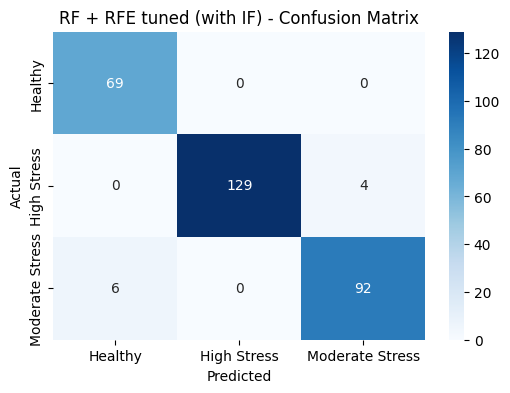

In [22]:
y_train_pred = best_rf.predict(X_train_rfe)
y_test_pred = best_rf.predict(X_test_rfe)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")

print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Confusion matrix + plot
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(
    cm,
    class_names=label_encoder.classes_,
    title="RF + RFE tuned (with IF) - Confusion Matrix",
    filename="rf_best_rfe_cm.png",
)

In [23]:
cv_scores = cross_val_score(
    best_rf, X_train_rfe, y_train, cv=5, scoring="accuracy", n_jobs=-1
)
print("CV fold scores:", cv_scores)
print("CV mean:", cv_scores.mean(), "std:", cv_scores.std())

CV fold scores: [0.99415205 0.99415205 1.         0.98830409 1.        ]
CV mean: 0.9953216374269005 std: 0.0043762074699110485


## ROC Curve Plot

Test AUC (macro): 0.9956


0.9955757249360806

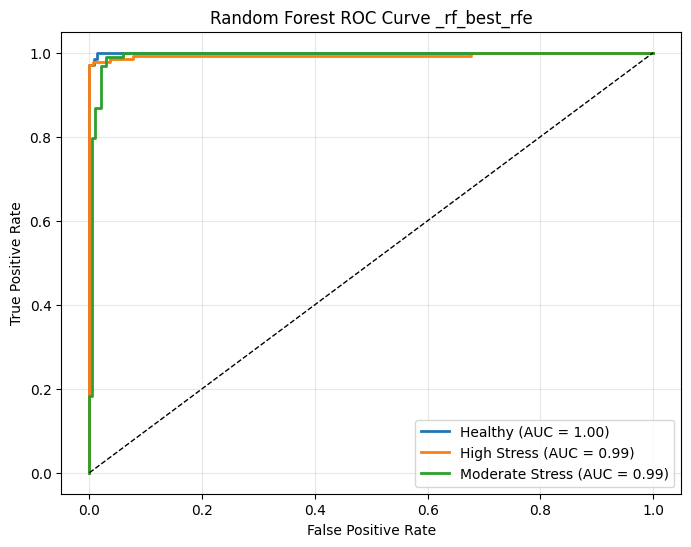

In [24]:
auc_value = None
if hasattr(best_rf, "predict_proba"):
    auc_value = plot_roc_curve(
        best_rf,
        X_test_rfe,
        y_test,
        label_encoder,
        title_suffix="_rf_best_rfe",
    )
    print(f"Test AUC (macro): {auc_value:.4f}")
auc_value

## Feature Importances plot
Random forest classifier produces a feature importances plot. This plot clearly shows us there are 2 main features driving the classification of our dataset. This explains why random forest still achieves extremely high classification and AUC even after eliminating 5 features.

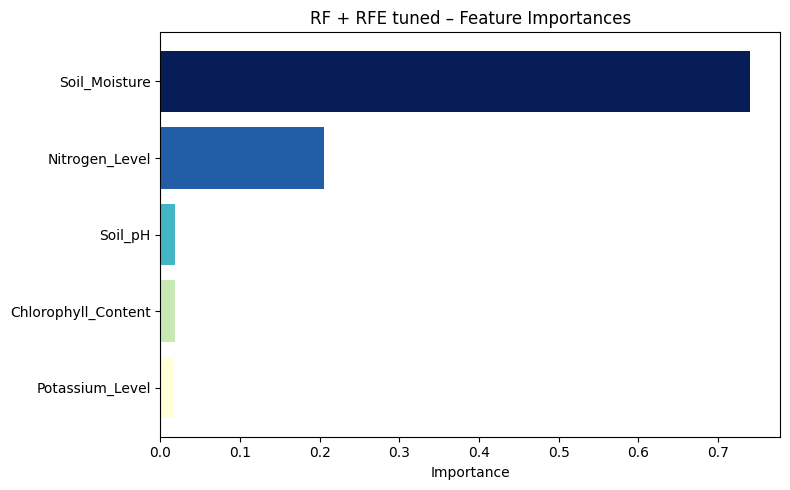

In [25]:
plot_feature_importances(
    best_rf,
    feature_names=selected_feature_names,
    title="RF + RFE tuned – Feature Importances",
    filename="rf_best_rfe_feature_importances.png",
)

## Summary / Conclusion

Using our best pipeline:

- IsolationForest removed a small portion of data points as outliers
- Recursive Feature Elimination selected the top 5 most informative features
- A tuned RandomForest with GridSearchCV achieved high train and test accuracy and near‑perfect AUC
- The confusion matrix and ROC curves show strong separation between plant health classes

Overall, Random Forest Classifier gave extremely high classification results for this dataset. We saw training accuracy of `1.00`, with testing accuracy of `0.9667`, and an AUC of `0.9956`.

### Some reasons for why the random forest classifier my be well suited for this dataset
- Looking at our feature importances plot, we can see there are two main features driving the predictions. Soil mosture accounts for ~63% of the predictive power, and Nitrogen level is ~16%. This shows the outcome is strongly determined by only 2 of the features, which limits the amount of branching we need in the decision trees.
- Our dataset is numeric, nonlinear data which works very well with random forest classifiers
- Our dataset also appears very clean, there is minimal noise, and we don't see any drop in classification performance when we keep the outliers in the data. 

### Additional Notes
Please refer to `src/alex/random_forest_analysis.ipynb` to view similar results with testing on multiple scenarios of using / not using feature selection and grid search. This notebook also confirms these results found.